In [1]:
using RCall, DataFrames, ModelingToolkit, DifferentialEquations

figsize = (;width,height) -> RCall.ijulia_setdevice(MIME("image/svg+xml"); width, height)
R"
require(tidyverse)
theme_set(theme_bw())
";

┌ Warning: RCall.jl: Loading required package: tidyverse
│ ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
│ ✔ ggplot2 3.4.0     ✔ purrr   1.0.1
│ ✔ tibble  3.1.8     ✔ dplyr   1.1.0
│ ✔ tidyr   1.3.0     ✔ stringr 1.5.0
│ ✔ readr   2.1.3     ✔ forcats 1.0.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


In [2]:
run(pipeline(`echo '

digraph {
    label = <J = I + ηA>
    labelloc = b
    layout=dot
    {
        rank=same
        S -> I [label=βSJ] // new infection 
        I -> R [label=γI] // recover
        R -> S [label=<<br/>μR>] // immunity waning
    }
    R -> A [label=<αRJ   >] // reinfection with (partial) immunity
    A -> R [label=δA] // recover
}        

'`, `dot -Tpng`, "SIRA.png"));

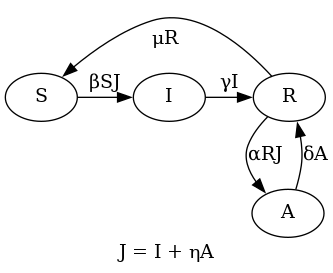

In [3]:
display(MIME"image/png"(), read("SIRA.png"))

In [4]:
@parameters t η β γ μ α δ
@variables S(t) I(t) R(t) A(t) J(t)
@variables I_new(t) I_re(t)
D = Differential(t)
@named dynamics = ODESystem(
    [
        J ~ I + η*A,
        D(S) ~ μ*R - I_new,
        D(I) ~ I_new - γ*I,
        D(A) ~ I_re - δ*A,
        D(R) ~ (γ*I-μ*R) + (δ*A - I_re),
        I_new ~ β*S*J,
        I_re ~ α*R*J
    ]
)

Model dynamics with 7 equations
States (7):
  S(t)
  I(t)
  A(t)
  R(t)
  J(t)
  I_new(t)
⋮
Parameters (6):
  η
  μ
  γ
  δ
  β
  α

In [5]:
R0 = 2.5 # = β/γ ⟸ A(0)=0
generation_interval = 5 # = 1/γ
I0 = .01 # = I(0)
longevity_of_immunity = 100 # = 1/μ
relative_infectivity_with_reinfection = 1/2 # = η

prob = ODEProblem(
    structural_simplify(dynamics),
    [ S => 1-I0, I => I0, A => 0, R => 0 ], # initial states       
    (0, 365.25 * 100), # period of simulation
    [
        η => relative_infectivity_with_reinfection,
        β => R0/generation_interval,
        γ => 1/generation_interval,
        μ => 1/longevity_of_immunity,
        α => R0/generation_interval,
        δ => 1/generation_interval
    ]
)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 36525.0)
u0: 4-element Vector{Float64}:
 0.99
 0.01
 0.0
 0.0

 18.667267 seconds (21.14 M allocations: 1.144 GiB, 1.86% gc time, 99.39% compilation time)


┌ Warning: RCall.jl: Loading required package: scales
│ 
│ Attaching package: ‘scales’
│ 
│ The following object is masked from ‘package:purrr’:
│ 
│     discard
│ 
│ The following object is masked from ‘package:readr’:
│ 
│     col_factor
│ 
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: Loading required package: patchwork
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: Joining with `by = join_by(R0)`
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: Warning: Transformation introduced infinite values in continuous y-axis
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


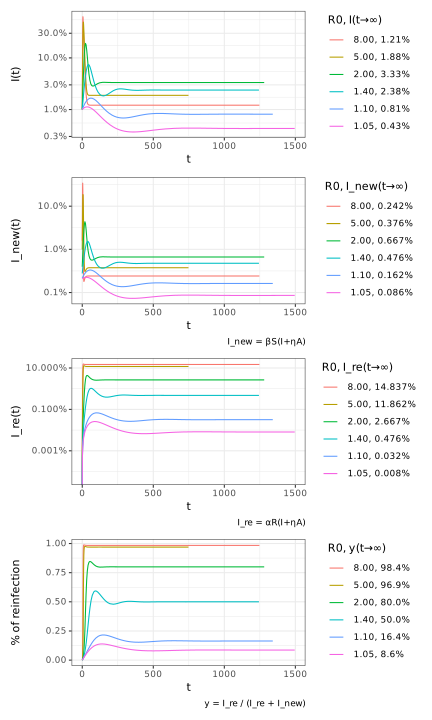

RObject{VecSxp}


In [6]:
df = DataFrame()
@time for R0 in [1.05, 1.1, 1.4, 2, 5, 8]
    sol = solve(
        remake(prob; p = [ β => R0/generation_interval, α => R0/generation_interval ]),
        # alg_hints = [:stiff]
    )
    append!(df, DataFrame(;
            R0,
            t=sol[t],                
            [Symbol(s) => sol[s] for s in states(dynamics)]...,
            Symbol("% of reinfection") => sol[I_re/(I_re+I_new)]
            )
    )
end

figsize(width=6, height=10)
R"
require(scales)
require(patchwork)

$df %>%
    # make labels
    group_by(R0) %>%
    summarise_all(last) %>%
    transmute(
        R0,
        `I(∞)` = `I(t)`,
        `I_new(∞)` = `I_new(t)`,
        `I_re(∞)` = `I_re(t)`,
        `% of reinfection(∞)` = `% of reinfection`
    ) %>%
    left_join($df, multiple='all') %>%
    mutate(
        label_I = {
            t = sprintf('%5.2f, %s', R0, percent(`I(∞)`))
            factor(t, level=str_sort(unique(t), numeric=TRUE, decreasing=TRUE))
        },
        label_I_new = {
            t = sprintf('%5.2f, %s', R0, percent(`I_new(∞)`))
            factor(t, level=str_sort(unique(t), numeric=TRUE, decreasing=TRUE))
        },
        label_I_re = {
            t = sprintf('%5.2f, %s', R0, percent(`I_re(∞)`))
            factor(t, level=str_sort(unique(t), numeric=TRUE, decreasing=TRUE))
        },
        label_pct_reinf = {
            t = sprintf('%5.2f, %s', R0, percent(`% of reinfection(∞)`))
            factor(t, level=str_sort(unique(t), numeric=TRUE, decreasing=TRUE))
        }
    ) %>%
    filter(t < 1500) -> df    

g_I = df %>%
    ggplot() + 
    geom_line(aes(t, `I(t)`, col=label_I)) +
    scale_y_log10(labels = percent) +
    labs(
        color = 'R0, I(t→∞)'
    )

g_I_new = df %>%
    ggplot() + 
    geom_line(aes(t, `I_new(t)`, col=label_I_new)) +
    scale_y_log10(labels = percent) +
    labs(
        color = 'R0, I_new(t→∞)',
        caption = 'I_new = βS(I+ηA)'
    )

g_I_re = df %>%
    ggplot() + 
    geom_line(aes(t, `I_re(t)`, col=label_I_re)) +
    scale_y_log10(labels = percent) +
    labs(
        color = 'R0, I_re(t→∞)',
        caption = 'I_re = αR(I+ηA)'
    )

g_pct_reinf = df %>%
    ggplot() +
    geom_line(aes(t, `% of reinfection`, col=label_pct_reinf)) +
    # scale_y_log10(labels = percent) +
    labs(
        color = 'R0, y(t→∞)',
        caption = 'y = I_re / (I_re + I_new)'
    )

g_I / g_I_new / g_I_re / g_pct_reinf
"

In [7]:
df = DataFrame()
ηs = range(0, 1, length=100)
R0s = exp.(range(log(1.01), log(10), length=100))
@time for relative_infectivity in ηs, R0 in R0s
    # loop
    sol = solve(
        remake(
            prob;
            p = [
                β => R0/generation_interval,
                α => R0/generation_interval,
                η => relative_infectivity
            ]
        )
    )
    append!(df, DataFrame(;
            η=relative_infectivity,
            R0,
            Symbol("S(∞)") => sol[S][end],
            Symbol("I(∞)") => sol[I][end],
            Symbol("A(∞)") => sol[A][end],
            Symbol("R(∞)") => sol[R][end],            
            Symbol("J(∞)") => sol[J][end],            
            Symbol("I_new(∞)") => sol[I_new][end],
            Symbol("I_re(∞)") => sol[I_re][end],
            Symbol("A/(S+I)") => sol[A/(S+I)][end],
            Symbol("I_new/(I_new+I_re)") => sol[I_new/(I_new+I_re)][end],
            Symbol("I_new(∞)+I_re(∞)") => sol[I_new+I_re][end],
            Symbol("I_new(∞)+I_re(∞)/2") => sol[I_new+I_re/2][end],
            Symbol("I_new(∞)+I_re(∞)/10") => sol[I_new+I_re/10][end],
            Symbol("I_new(∞)+I_re(∞)/25") => sol[I_new+I_re/25][end],
            Symbol("I_new(∞)+I_re(∞)/30") => sol[I_new+I_re/30][end],
            Symbol("I_new(∞)+I_re(∞)/50") => sol[I_new+I_re/50][end],
            )
    )
end

 23.663708 seconds (92.62 M allocations: 5.985 GiB, 8.19% gc time, 8.67% compilation time)


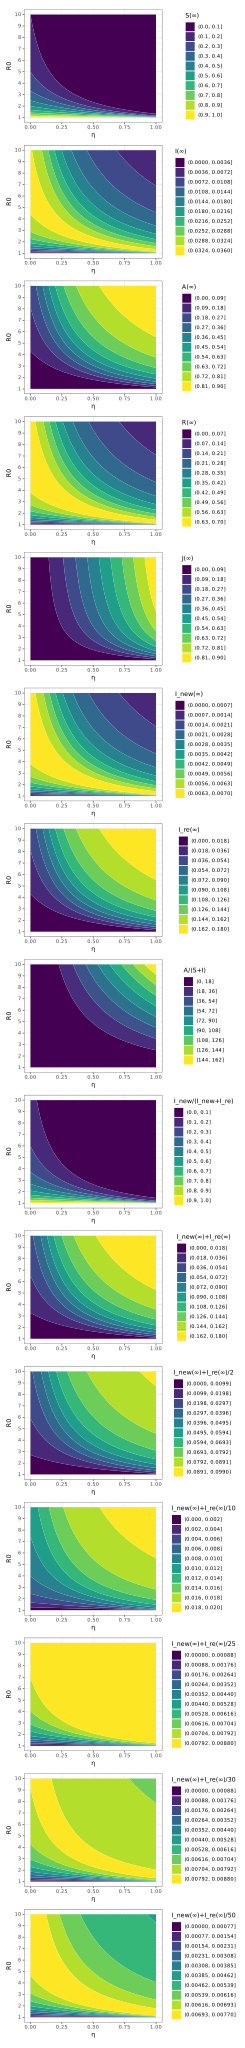

RObject{VecSxp}


In [8]:
figsize(width=6, height=50)
R"
require(scales)
require(patchwork)

g_acc = NULL
for(col in colnames($df)[3:ncol($df)]) {
    g = ggplot($df) +
        geom_contour_filled(aes(η,R0,z=!!sym(col)), bins=10) + 
        scale_y_continuous(breaks = breaks_width(1)) +
        labs(fill = col)
    if(is.null(g_acc)) {
        g_acc = g
    } else {
        g_acc = g_acc / g
    }
}
g_acc
"